In [11]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback

import progressbar

In [12]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        if len(text) > 3:
                            sentence = zip(text, label)
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [13]:
data_list = read_data('../data/')

print data_list[0]

data_list = data_list[:2000]

train_test_cutoff = int(.70 * len(data_list)) 
training_sentences = data_list[:train_test_cutoff]
testing_sentences = data_list[train_test_cutoff:]
 
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

[('A', 'NA'), ('Hybrid', 'NA'), ('Photoreceptor', 'NA'), ('Expressing', 'NA'), ('Both', 'NA'), ('Rod', 'NA'), ('and', 'NA'), ('Cone', 'NA'), ('Genes', 'NA'), ('in', 'NA'), ('a', 'NA'), ('Mouse', 'NA'), ('Model', 'NA'), ('of', 'NA'), ('Enhanced', 'NA'), ('SCone', 'NA'), ('Syndrome', 'NA')]


In [14]:
print training_sentences[0]

[('Peptides', 'NA'), ('linked', 'NA'), ('to', 'NA'), ('KLH', 'NA'), ('keyhole', 'NA'), ('limpet', 'NA'), ('hemacyanin', 'NA'), ('from', 'NA'), ('Acdp1', 'NA'), ('N', 'NA'), ('and', 'NA'), ('Cterminals', 'NA'), ('and', 'NA'), ('the', 'NA'), ('conserved', 'NA'), ('domain', 'NA'), ('ACD', 'NA'), ('were', 'NA'), ('used', 'NA'), ('for', 'NA'), ('generation', 'NA'), ('of', 'NA'), ('antibodies', 'GO:0019814'), ('specifically', 'NA'), ('for', 'NA'), ('Acdp1', 'NA'), ('and', 'NA'), ('all', 'NA'), ('Acdp', 'NA'), ('members', 'NA'), ('as', 'NA'), ('reported', 'NA'), ('respectively', 'NA'), ('The', 'NA'), ('membranes', 'NA'), ('were', 'NA'), ('washed', 'NA'), ('extensively', 'NA'), ('after', 'NA'), ('incubation', 'NA'), ('with', 'NA'), ('primary', 'NA'), ('and', 'NA'), ('secondary', 'NA'), ('antibodies', 'GO:0019814'), ('and', 'NA'), ('were', 'NA'), ('then', 'NA'), ('developed', 'NA'), ('with', 'NA'), ('Xray', 'NA'), ('films', 'NA'), ('with', 'NA'), ('optimal', 'NA'), ('exposure', 'NA'), ('time', 

In [15]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
 
        :param sentence_terms: [w1, w2, ...] 
        :type sentence_terms: list
        :param index: the index of the word 
        :type index: int
        :return: dict containing features
        :rtype: dict
    """

    term = sentence_terms[index]

    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [16]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term. 
 
    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]
 
def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
 
    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []
 
    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

In [17]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

In [18]:
from sklearn.feature_extraction import DictVectorizer
 
# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=False)

In [19]:
# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

In [20]:
# Fit LabelEncoder with our list of classes
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

LabelEncoder()

In [21]:
# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [22]:
# Convert integers to dummy variables (one hot encoded)
from keras.utils import np_utils
 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(66636, 48032) (39712, 48032) (66636, 61) (39712, 61)


In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
 
def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
# from keras.callbacks import Callback
# from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
# import numpy as np

# class Metrics(Callback):

#     def on_train_begin(self, logs={}):
#         self.val_f1s = []
#         self.val_recalls = []
#         self.val_precisions = []

#     def on_epoch_end(self, epoch, logs={}):
#         val_predict = (np.asarray(self.model.predict(self.model.validation_data[0]))).round()
#         val_targ = self.model.validation_data[1]
#         _val_f1 = f1_score(val_targ, val_predict)
#         _val_recall = recall_score(val_targ, val_predict)
#         _val_precision = precision_score(val_targ, val_predict)
#         self.val_f1s.append(_val_f1)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
#         print " — val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall)
#         return

# metrics = Metrics()

In [25]:
from keras.wrappers.scikit_learn import KerasClassifier
 
model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}
 
clf = KerasClassifier(**model_params)

In [26]:
hist = clf.fit(X_train, y_train)

Train on 66636 samples, validate on 21775 samples
Epoch 1/5
66636/66636 [==============================] - 118s - loss: 0.1779 - acc: 0.9833 - val_loss: 0.0734 - val_acc: 0.9929
Epoch 2/5
66636/66636 [==============================] - 115s - loss: 0.0256 - acc: 0.9953 - val_loss: 0.0584 - val_acc: 0.9948
Epoch 3/5
66636/66636 [==============================] - 115s - loss: 0.0133 - acc: 0.9973 - val_loss: 0.0630 - val_acc: 0.9951
Epoch 4/5
66636/66636 [==============================] - 117s - loss: 0.0097 - acc: 0.9980 - val_loss: 0.0630 - val_acc: 0.9950
Epoch 5/5
66636/66636 [==============================] - 116s - loss: 0.0080 - acc: 0.9982 - val_loss: 0.0599 - val_acc: 0.9938


In [27]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
 
    green = '#72C29B'
    orange = '#FFA577'
 
    with plt.xkcd():
        # plot model loss
        fig, ax1 = plt.subplots()
        ax1.plot(range(1, len(train_loss) + 1), train_loss, green, linewidth=5,
                 label='training')
        ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, orange,
                 linewidth=5, label='validation')
        ax1.set_xlabel('# epoch')
        ax1.set_ylabel('loss')
        ax1.tick_params('y')
        ax1.legend(loc='upper right', shadow=False)
        # plot model accuracy
        fig, ax2 = plt.subplots()
        ax2.plot(range(1, len(train_acc) + 1), train_acc, green, linewidth=5,
                 label='training')
        ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, orange,
                 linewidth=5, label='validation')
        ax2.set_xlabel('# epoch')
        ax2.set_ylabel('accuracy')
        ax2.tick_params('y')
        ax2.legend(loc='lower right', shadow=False)

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'xkcd', u'Humor Sans', u'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


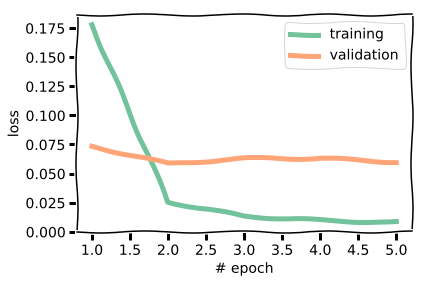

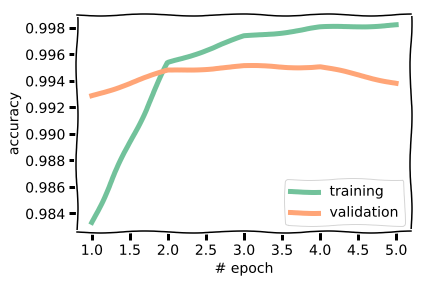

In [28]:
# Plot model performance
plot_model_performance(
    train_loss=hist.history.get('loss', []),
    train_acc=hist.history.get('acc', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc=hist.history.get('val_acc', [])
)

In [29]:
score = clf.score(X_test, y_test)
print(score)

39680/39712 [============================>.] - ETA: 0s0.992521152297


In [31]:
from sklearn.metrics import classification_report
predicted = clf.predict(X_test)
predicted_cat = np_utils.to_categorical(predicted)

39680/39712 [============================>.] - ETA: 0s             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.00      0.00      0.00         0
          2       0.00      0.00      0.00         0
          3       0.94      1.00      0.97        47
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         0
          6       0.08      1.00      0.16         5
          7       0.00      0.00      0.00         8
          8       0.78      1.00      0.88         7
          9       0.00      0.00      0.00         7
         10       0.00      0.00      0.00         0
         11       0.00      0.00      0.00         1
         12       0.00      0.00      0.00         2
         13       0.00      0.00      0.00         5
         14       0.00      0.00      0.00        11
         15       0.00      0.00      0.00         2
         16       0.96      1.00      0.98  

In [36]:
# print y_test
# print predicted_cat
report = classification_report(y_test, predicted_cat, target_names=label_encoder.classes_)
print "\n"
print report



             precision    recall  f1-score   support

 GO:0000267       0.00      0.00      0.00         1
 GO:0000502       0.00      0.00      0.00         0
 GO:0000775       0.00      0.00      0.00         0
 GO:0000785       0.94      1.00      0.97        47
 GO:0000786       0.00      0.00      0.00         0
 GO:0000791       0.00      0.00      0.00         0
 GO:0000792       0.08      1.00      0.16         5
 GO:0000795       0.00      0.00      0.00         8
 GO:0000805       0.78      1.00      0.88         7
 GO:0000806       0.00      0.00      0.00         7
 GO:0001917       0.00      0.00      0.00         0
 GO:0005575       0.00      0.00      0.00         1
 GO:0005576       0.00      0.00      0.00         2
 GO:0005577       0.00      0.00      0.00         5
 GO:0005581       0.00      0.00      0.00        11
 GO:0005622       0.00      0.00      0.00         2
 GO:0005623       0.96      1.00      0.98       363
 GO:0005634       0.88      1.00      0.94 

In [35]:
label_encoder.classes_

array(['GO:0000267', 'GO:0000502', 'GO:0000775', 'GO:0000785',
       'GO:0000786', 'GO:0000791', 'GO:0000792', 'GO:0000795',
       'GO:0000805', 'GO:0000806', 'GO:0001917', 'GO:0005575',
       'GO:0005576', 'GO:0005577', 'GO:0005581', 'GO:0005622',
       'GO:0005623', 'GO:0005634', 'GO:0005643', 'GO:0005675',
       'GO:0005694', 'GO:0005712', 'GO:0005730', 'GO:0005737',
       'GO:0005739', 'GO:0005777', 'GO:0005829', 'GO:0005833',
       'GO:0005840', 'GO:0005856', 'GO:0005871', 'GO:0005883',
       'GO:0005966', 'GO:0008305', 'GO:0010369', 'GO:0014069',
       'GO:0016020', 'GO:0016021', 'GO:0016459', 'GO:0017086',
       'GO:0019814', 'GO:0030054', 'GO:0030286', 'GO:0030424',
       'GO:0030425', 'GO:0030849', 'GO:0031982', 'GO:0032991',
       'GO:0042470', 'GO:0042995', 'GO:0043025', 'GO:0043209',
       'GO:0043226', 'GO:0043679', 'GO:0045120', 'GO:0045177',
       'GO:0045202', 'GO:0045277', 'GO:0045298', 'GO:0048471', 'NA'],
      dtype='|S10')